<a href="https://colab.research.google.com/github/khsoukaina/FMM/blob/main/FMM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

class MatrixMultiplicationModel(nn.Module):
    def __init__(self, input_channels=2, matrix_size=8):
        super(MatrixMultiplicationModel, self).__init__()
        self.matrix_size = matrix_size
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * matrix_size * matrix_size, 512)
        self.fc2 = nn.Linear(512, matrix_size * matrix_size)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, self.matrix_size, self.matrix_size)
        return x

def generate_matrices(size):
    A = np.random.rand(size, size).astype(np.float32)
    B = np.random.rand(size, size).astype(np.float32)
    return A, B

In [ ]:
def prepare_training_data(matrix_size, num_samples=1000):
    X = []
    y = []
    for _ in range(num_samples):
        A, B = generate_matrices(matrix_size)
        C = np.dot(A, B)
        X.append(np.stack([A, B], axis=0))
        y.append(C)
    return np.array(X), np.array(y)

In [ ]:

def train_model(model, data_loader, criterion, optimizer, epochs=10, device="cpu"):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses


In [ ]:
def visualize_matrix_multiplication(A, B, C_pred, C_real):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0, 0].imshow(A, cmap='Blues')
    axes[0, 0].set_title("Matrix A")
    axes[0, 1].imshow(B, cmap='Greens')
    axes[0, 1].set_title("Matrix B")
    axes[1, 0].imshow(C_real, cmap='Purples')
    axes[1, 0].set_title("Real Product (Naive)")
    axes[1, 1].imshow(C_pred, cmap='Oranges')
    axes[1, 1].set_title("Predicted Product (NN)")
    plt.tight_layout()
    plt.show()


    diff = np.abs(C_real - C_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(diff, cmap="Reds")
    plt.colorbar(label="Difference Magnitude")
    plt.title("Difference between Real and Predicted Product")
    plt.show()

In [ ]:
def test_model(matrix_size=8, num_samples=1000, epochs=10, batch_size=16, device="cpu"):

    X_train, y_train = prepare_training_data(matrix_size, num_samples)
    X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)

    X_train /= X_train.max()
    y_train /= y_train.max()


    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


    model = MatrixMultiplicationModel(input_channels=2, matrix_size=matrix_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    losses = train_model(model, data_loader, criterion, optimizer, epochs, device)

    # Visualisation 1
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), losses, label="Training Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss during Training")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Test
    A, B = generate_matrices(matrix_size)
    C_real = np.dot(A, B)


    X_test = np.stack([A, B], axis=0).astype(np.float32)
    X_test_tensor = torch.tensor(X_test).unsqueeze(0).to(device)

    # prediction
    model.eval()
    with torch.no_grad():
        C_pred_tensor = model(X_test_tensor)
    C_pred = C_pred_tensor.cpu().numpy().squeeze()

    # Visualisation des résultats
    visualize_matrix_multiplication(A, B, C_pred, C_real)

    # affichage et calcul
    diff = np.abs(C_real - C_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(diff, cmap="Reds")
    plt.colorbar(label="Difference Magnitude")
    plt.title("Difference between Real and Predicted Product")
    plt.show()

    return C_real, C_pred


Epoch 1/20, Loss: 0.0262
Epoch 2/20, Loss: 0.0116
Epoch 3/20, Loss: 0.0062
Epoch 4/20, Loss: 0.0034
Epoch 5/20, Loss: 0.0028
Epoch 6/20, Loss: 0.0024
Epoch 7/20, Loss: 0.0022
Epoch 8/20, Loss: 0.0020
Epoch 9/20, Loss: 0.0019
Epoch 10/20, Loss: 0.0020
Epoch 11/20, Loss: 0.0017
Epoch 12/20, Loss: 0.0014
Epoch 13/20, Loss: 0.0013
Epoch 14/20, Loss: 0.0011
Epoch 15/20, Loss: 0.0010
Epoch 16/20, Loss: 0.0009
Epoch 17/20, Loss: 0.0008
Epoch 18/20, Loss: 0.0008
Epoch 19/20, Loss: 0.0010
Epoch 20/20, Loss: 0.0008


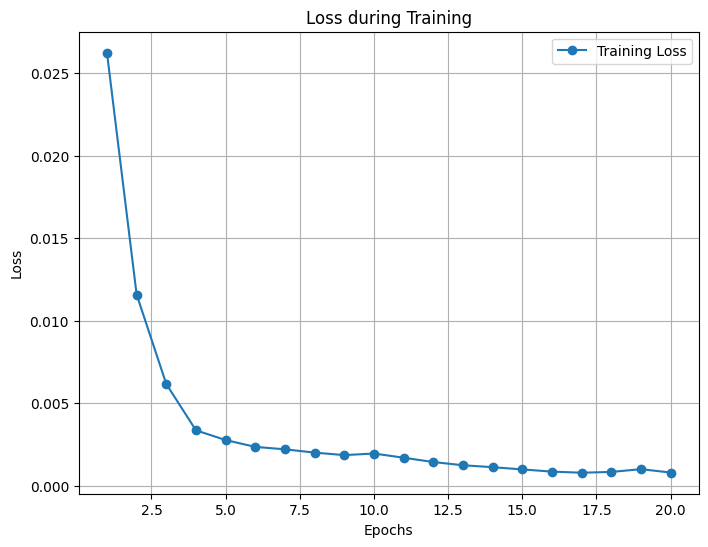

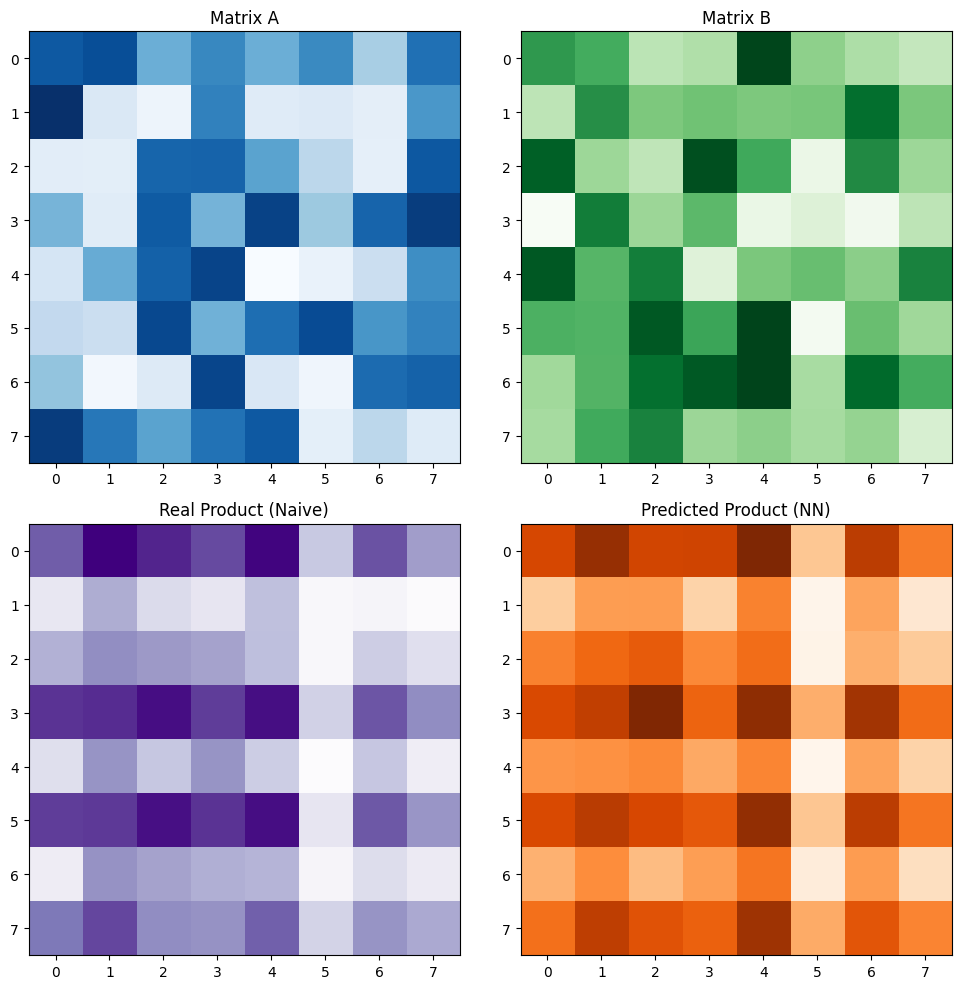

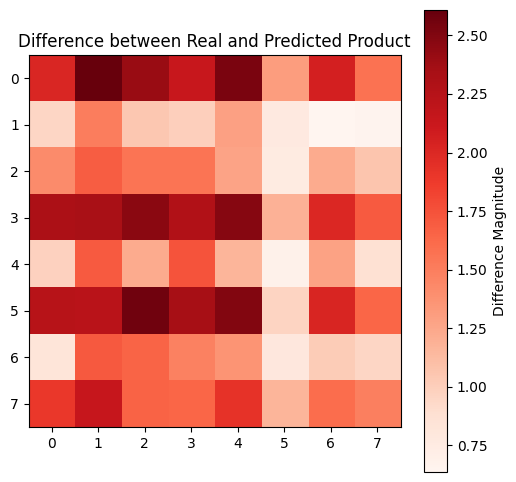

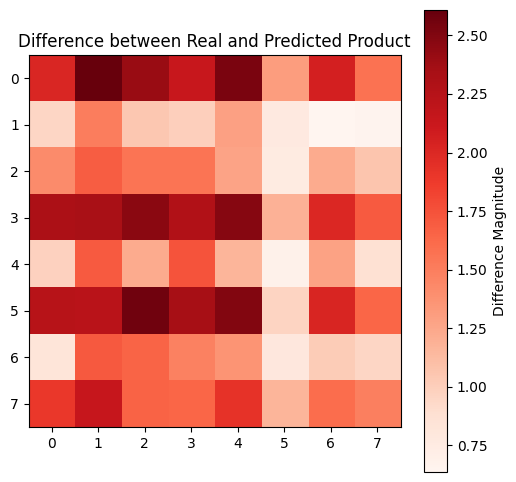

In [ ]:

if __name__ == "__main__":
    matrix_size = 8
    num_samples = 1000
    epochs = 20
    device = "cuda" if torch.cuda.is_available() else "cpu"
    test_model(matrix_size, num_samples, epochs, device=device)